# Car Price Prediction with AdaBoost, GradientBoost, XGBoost Regressors

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams["figure.figsize"] = (7,4)
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

In [2]:
df=pd.read_csv("car_dataset.csv")
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [3]:
df.shape

(301, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [5]:
df.isnull().any().any()

False

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,301.0,2013.627907,2.891554,2003.00,2012.0,2014.0,2016.0,2018.0
Selling_Price,301.0,4.661296,5.082812,0.10,0.9,3.6,6.0,35.0
Present_Price,301.0,7.628472,8.644115,0.32,1.2,6.4,9.9,92.6
Kms_Driven,301.0,36947.205980,38886.883882,500.00,15000.0,32000.0,48767.0,500000.0
Owner,301.0,0.043189,0.247915,0.00,0.0,0.0,0.0,3.0


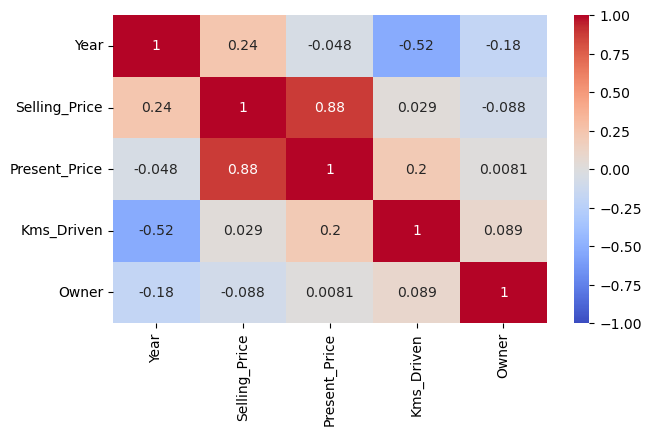

In [9]:
sns.heatmap(df.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, cmap="coolwarm")
plt.show()

In [10]:
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [11]:
df["vehicle_age"]=2022-df.Year

In [12]:
df.Car_Name.value_counts().head(10)

Car_Name
city             26
corolla altis    16
verna            14
fortuner         11
brio             10
ciaz              9
innova            9
i20               9
grand i10         8
jazz              7
Name: count, dtype: int64

In [13]:
df.drop(columns=["Car_Name", "Year"], inplace=True)

In [14]:
df.head()

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,vehicle_age
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,8
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,9
2,7.25,9.85,6900,Petrol,Dealer,Manual,0,5
3,2.85,4.15,5200,Petrol,Dealer,Manual,0,11
4,4.60,6.87,42450,Diesel,Dealer,Manual,0,8


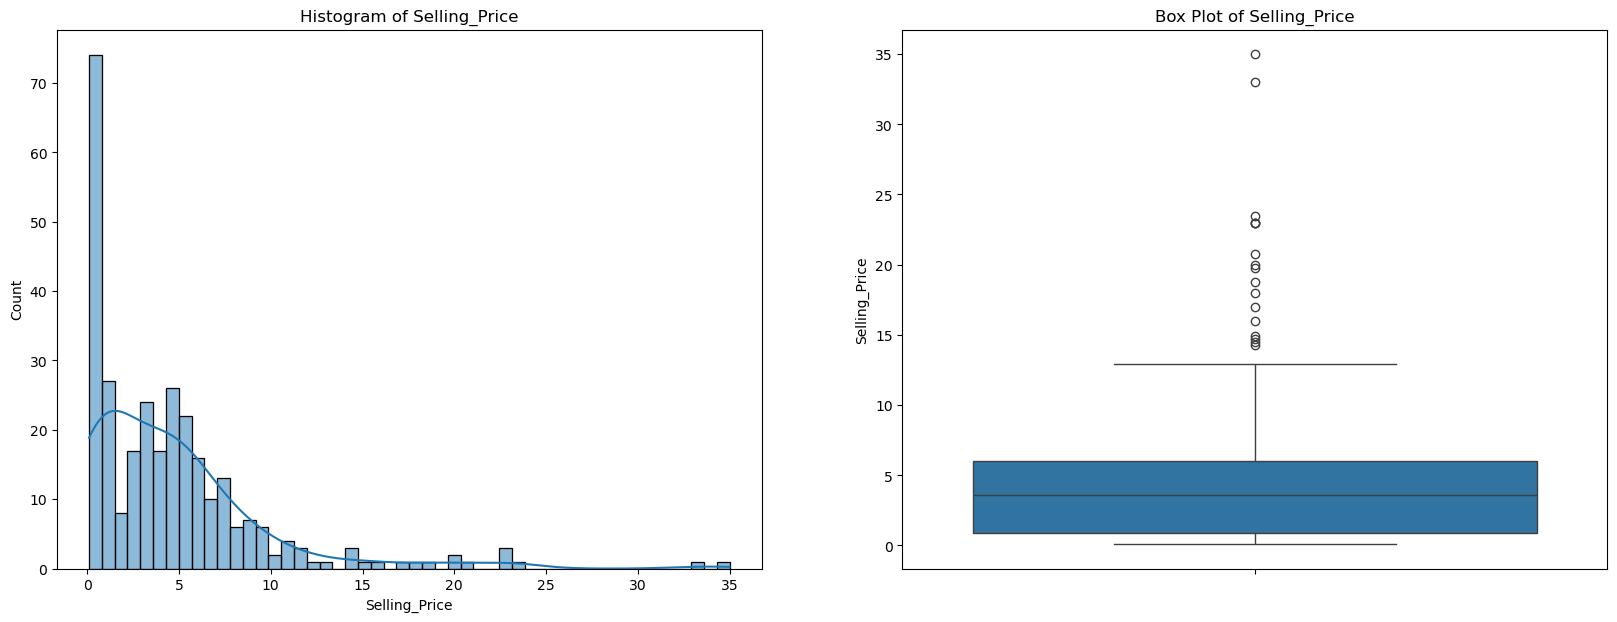

In [15]:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.title("Histogram of Selling_Price")
sns.histplot(df.Selling_Price, bins=50, kde=True)
plt.subplot(1,2,2)
plt.title("Box Plot of Selling_Price")
sns.boxplot(df.Selling_Price);

## Train test split

In [16]:
from sklearn.preprocessing import OrdinalEncoder

In [17]:
df_new = df[df.Selling_Price < 10]
df_new.head()

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,vehicle_age
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,8
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,9
2,7.25,9.85,6900,Petrol,Dealer,Manual,0,5
3,2.85,4.15,5200,Petrol,Dealer,Manual,0,11
4,4.60,6.87,42450,Diesel,Dealer,Manual,0,8


In [18]:
X=df_new.drop("Selling_Price", axis=1)
y=df_new.Selling_Price

In [19]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=5)

print("Train features shape : ", X_train.shape)
print("Train target shape   : ", y_train.shape)
print("Test features shape  : ", X_test.shape)
print("Test target shape    : ", y_test.shape)


Train features shape :  (218, 7)
Train target shape   :  (218,)
Test features shape  :  (55, 7)
Test target shape    :  (55,)


## Modeling with Pipeline for Adaboost Regressor

In [20]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [21]:
def train_val(model, X_train, y_train, X_test, y_test):

    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    scores = {"train": {"R2" : r2_score(y_train, y_train_pred),
    "mae" : mean_absolute_error(y_train, y_train_pred),
    "mse" : mean_squared_error(y_train, y_train_pred),
    "rmse" : mean_squared_error(y_train, y_train_pred, squared=False),
    "mape" :mean_absolute_percentage_error(y_train, y_train_pred)},

    "test": {"R2" : r2_score(y_test, y_pred),
    "mae" : mean_absolute_error(y_test, y_pred),
    "mse" : mean_squared_error(y_test, y_pred),
    "rmse" : mean_squared_error(y_test, y_pred, squared=False),
    "mape" :mean_absolute_percentage_error(y_test, y_pred)}}

    return pd.DataFrame(scores)

In [22]:
cat = X.select_dtypes("object").columns
cat

Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object')

In [23]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder


ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value',
                         unknown_value=-1)

column_trans = make_column_transformer((ord_enc, cat),
                                        remainder='passthrough',
                                        verbose_feature_names_out=False).set_output(transform="pandas")

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostRegressor

#base_estimator=DecisionTreeRegressor(max_depth=3)
operations = [("OrdinalEncoder", column_trans),
              ("Ada_model", AdaBoostRegressor(random_state=11))]

pipe_model = Pipeline(steps=operations)

pipe_model.fit(X_train, y_train)

# adaboostregressor algorithm uses base_estimator=DecisionTreeRegressor(max_depth=3) by default.

# In adaboostregressor, the predictions found by each tree are weighted and the final prediction is returned.

# For example, we give an observation to the model for prediction;
# 1st tree predicted this observation at 5;
# 2nd tree predicted 7;
# 3rd tree predicted 9.

# Let's assume that the 1st tree weighs 2, the second tree weighs 1, and the third tree weighs 0.5.

# does the calculation, taking into account the weights, as follows:
# pred = (prediction of 1st tree x weight of 1st tree + estimate of 2nd tree x 2nd tree's weight +
# 3rd tree's estimate x 3rd tree weight) / (1st tree weight + 2nd tree's weight + 3rd tree's weight) )
# (5x2 + 7x1 + 9x0.5) / (2 + 1 + 0.5) = 6.14

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('Ada_model', AdaBoostRegressor(random_state=11))])

In [25]:
train_val(pipe_model, X_train, y_train, X_test, y_test)

# overfiting? will confirmed with CV.

,train,test
R2,0.963733,0.946141
mae,0.397661,0.436586
mse,0.261686,0.367964
rmse,0.511553,0.606600
mape,0.243271,0.480799


In [26]:
y_pred_ada = pipe_model.predict(X_test)
y_pred_ada

array([0.56875   , 5.4296875 , 5.35909091, 0.56875   , 6.95478873,
       0.56875   , 3.44631579, 4.98225806, 0.7075    , 0.7075    ,
       4.98225806, 4.4262963 , 7.11851852, 4.52647059, 4.72941176,
       0.48208333, 5.625     , 4.98225806, 7.07321429, 0.53571429,
       0.56875   , 2.96036364, 4.85588235, 0.598     , 2.87096774,
       0.53571429, 1.22916667, 1.05      , 0.598     , 1.22363636,
       0.52166667, 7.0025641 , 0.56875   , 0.56875   , 4.923     ,
       0.56875   , 6.95478873, 1.4375    , 5.5862069 , 4.634     ,
       7.95220588, 4.20450704, 4.98225806, 7.02254902, 7.0025641 ,
       0.56875   , 1.22363636, 1.43      , 2.455     , 1.22916667,
       5.675     , 1.30772727, 5.3656    , 3.18461538, 3.98382353])

In [27]:
from sklearn.model_selection import cross_validate

operations = [("OrdinalEncoder", column_trans),
              ("Ada_model", AdaBoostRegressor(random_state=101))]

model = Pipeline(steps=operations)

scores = cross_validate(model,
                        X_train,
                        y_train,
                        scoring=['r2',
                                 'neg_mean_absolute_error',
                                 'neg_mean_squared_error',
                                 'neg_root_mean_squared_error',
                                 'neg_mean_absolute_percentage_error'],
                        cv =10,
                        return_train_score=True)
pd.DataFrame(scores)
pd.DataFrame(scores).mean()[2:]

# scores not consistent with vanilla scores.

test_r2                                     0.917422
train_r2                                    0.963272
test_neg_mean_absolute_error               -0.520943
train_neg_mean_absolute_error              -0.393707
test_neg_mean_squared_error                -0.540584
train_neg_mean_squared_error               -0.265154
test_neg_root_mean_squared_error           -0.714772
train_neg_root_mean_squared_error          -0.513041
test_neg_mean_absolute_percentage_error    -0.288376
train_neg_mean_absolute_percentage_error   -0.245260
dtype: float64

## Gridsearch for Adaboosting

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

In [29]:
AdaBoostRegressor?

Init signature:
AdaBoostRegressor(
    estimator=None,
    *,
    n_estimators=50,
    learning_rate=1.0,
    loss='linear',
    random_state=None,
    base_estimator='deprecated',
)
Docstring:     
An AdaBoost regressor.

An AdaBoost [1] regressor is a meta-estimator that begins by fitting a
regressor on the original dataset and then fits additional copies of the
regressor on the same dataset but where the weights of instances are
adjusted according to the error of the current prediction. As such,
subsequent regressors focus more on difficult cases.

This class implements the algorithm known as AdaBoost.R2 [2].

Read more in the :ref:`User Guide <adaboost>`.

.. versionadded:: 0.14

Parameters
----------
estimator : object, default=None
    The base estimator from which the boosted ensemble is built.
    If ``None``, then the base estimator is
    :class:`~sklearn.tree.DecisionTreeRegressor` initialized with
    `max_depth=3`.

    .. versionadded:: 1.2
       `base_estimator` was ren

In [30]:
base_estimators = [DecisionTreeRegressor(max_depth=i) for i in range(1,4)]

param_grid = {"Ada_model__estimator": base_estimators,
              "Ada_model__n_estimators":[50, 100],
              "Ada_model__learning_rate":[1, 1.1],
              "Ada_model__loss": ["linear", "square", "exponential"]
            }

# can also be played with the base estimator hyperparameters to eliminate overfitting.
# Unlike classification it is base_estimator=DecisionTreeRegressor(max_depth=3). (In classification max_dept=1.)
# loss specifies the function to be used for calculating tree weights. Its default is linear.
# The best loss function should be detected with Gridsearch.
# For the division condition of leaves, gini in classification and mse in regression are taken into account.

In [31]:
operations = [("OrdinalEncoder", column_trans),
              ("Ada_model", AdaBoostRegressor(random_state=101))]

model = Pipeline(steps=operations)

grid_model = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring='neg_mean_absolute_percentage_error',
                          cv=10,
                          n_jobs=-1,
                          return_train_score=True)

In [32]:
grid_model.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('OrdinalEncoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object'))],
                                                          verbose_feature_names_out=False)),
                                       ('Ada_model',
                                        AdaBoostRegressor(random_state=101))]),
             n_jobs=-1,
             param_grid={'Ada_model__estimator': [DecisionTreeRegressor(max_depth=1),
                                                  DecisionTreeRegressor(max_depth=2),
                                                  DecisionTreeRegressor(max_depth=3)],
                         'Ada_model__learning_rate': [1, 1.1],
                         'Ada_model__loss': ['linear', 'square', 'exponential'],
                         'Ada_model__n_estimators': [50, 100]},
             return_train_score=True,
             scoring='neg_mean_absolute_percentage_error')

In [33]:
grid_model.best_params_

{'Ada_model__estimator': DecisionTreeRegressor(max_depth=3),
 'Ada_model__learning_rate': 1,
 'Ada_model__loss': 'square',
 'Ada_model__n_estimators': 50}

In [34]:
grid_model.best_estimator_

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('Ada_model',
                 AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3),
                                   learning_rate=1, loss='square',
                                   random_state=101))])

In [35]:
pd.DataFrame(grid_model.cv_results_).loc[grid_model.best_index_, ["mean_test_score", "mean_train_score"]]

mean_test_score    -0.261514
mean_train_score   -0.222101
Name: 26, dtype: object

In [36]:
prediction = grid_model.predict(X_test)

ada_rmse = mean_squared_error(y_test, prediction, squared=False)

train_val(grid_model, X_train, y_train, X_test, y_test)

# CV and test set rmse scores are more consistent.

,train,test
R2,0.962436,0.942848
mae,0.386000,0.450503
mse,0.271042,0.390466
rmse,0.520617,0.624873
mape,0.206507,0.383470


## Feature importance

In [37]:
# Remove 'Ada_model__' prefix from parameter keys
best_params1 = {key.replace('Ada_model__', ''): value for key, value in grid_model.best_params_.items()}

In [38]:
operations = [("OrdinalEncoder", column_trans),
              ("Ada_model", AdaBoostRegressor(**best_params1))]

pipe_model = Pipeline(steps=operations)

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('Ada_model',
                 AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3),
                                   learning_rate=1, loss='square'))])

In [39]:
pipe_model["Ada_model"].feature_importances_

array([7.12847254e-02, 6.30072045e-03, 5.69668232e-03, 5.41418775e-01,
       1.19387482e-01, 2.82235731e-06, 2.55908792e-01])

In [40]:
features = pipe_model["OrdinalEncoder"].get_feature_names_out()
features

array(['Fuel_Type', 'Seller_Type', 'Transmission', 'Present_Price',
       'Kms_Driven', 'Owner', 'vehicle_age'], dtype=object)

In [41]:
imp_feats = pd.DataFrame(data=pipe_model["Ada_model"].feature_importances_,
                         columns=['ada_Importance'],
                         index=features)

ada_imp_feats = imp_feats.sort_values('ada_Importance', ascending=False)
ada_imp_feats

,ada_Importance
Present_Price,0.541419
vehicle_age,0.255909
Kms_Driven,0.119387
Fuel_Type,0.071285
Seller_Type,0.006301
Transmission,0.005697
Owner,0.000003


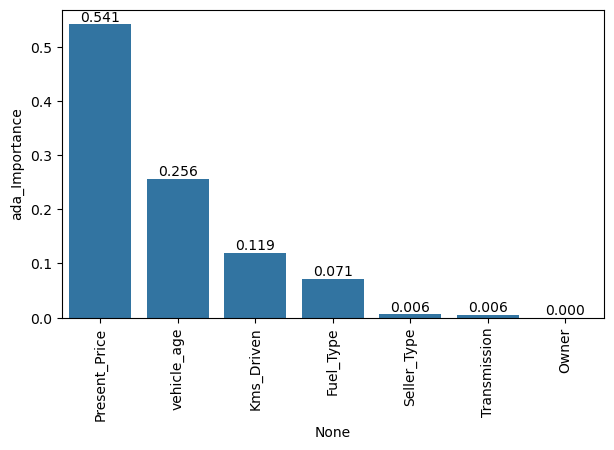

In [42]:
ax = sns.barplot(data=ada_imp_feats,
                 x=ada_imp_feats.index,
                 y='ada_Importance')

ax.bar_label(ax.containers[0],fmt="%.3f")
plt.xticks(rotation=90);

## Modeling with Pipeline for Gradient Boosting Regressor

In [43]:
from sklearn.ensemble import GradientBoostingRegressor

operations = [("OrdinalEncoder", column_trans),
              ("GB_model", GradientBoostingRegressor(random_state=101))]

pipe_model = Pipeline(steps=operations)

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('GB_model', GradientBoostingRegressor(random_state=101))])

In [44]:
# 100 -- 150 -- (-50) -- (-30) --> 150 + 0.1 *(-50) + 0.1*(-30)

# 200 -- 150 -- (50) -- (25) --> 150 + 0.1 *50 + 0.1*25

# In regression problems, the average of all observations in the data is taken.
# The difference (residuals) between these fixed values and the actual values is calculated.
# And the model tries to bring these residuals closer to 0.

# As in classification, the residual value calculated for each tree will be multiplied by
# the learning rate and added to the initial value to make an estimate.

# Suppose I have 2 instances in my data in the above example. Let's say the first car is 100$
# and the second car is 200$. The average value of all cars will be the starting value of the cars.
# And the values found in each tree will be added to this starting value.

In [45]:
train_val(pipe_model, X_train, y_train, X_test, y_test)

,train,test
R2,0.992788,0.952247
mae,0.165700,0.353392
mse,0.052040,0.326246
rmse,0.228124,0.571180
mape,0.075125,0.189853


In [46]:
operations = [("OrdinalEncoder", column_trans),
              ("GB_model", GradientBoostingRegressor(random_state=101))]

model = Pipeline(steps=operations)
scores = cross_validate(model,
                        X_train,
                        y_train,
                        scoring=['r2',
                                 'neg_mean_absolute_error',
                                 'neg_mean_squared_error',
                                 'neg_root_mean_squared_error',
                                 'neg_mean_absolute_percentage_error'],
                        cv =10,
                        return_train_score=True)

pd.DataFrame(scores).mean()[2:]

test_r2                                     0.948530
train_r2                                    0.993220
test_neg_mean_absolute_error               -0.392116
train_neg_mean_absolute_error              -0.158545
test_neg_mean_squared_error                -0.336418
train_neg_mean_squared_error               -0.048881
test_neg_root_mean_squared_error           -0.561606
train_neg_root_mean_squared_error          -0.220971
test_neg_mean_absolute_percentage_error    -0.170470
train_neg_mean_absolute_percentage_error   -0.072769
dtype: float64

## Gridsearch for Gradientboosting

In [47]:
GradientBoostingRegressor?

Init signature:
GradientBoostingRegressor(
    *,
    loss='squared_error',
    learning_rate=0.1,
    n_estimators=100,
    subsample=1.0,
    criterion='friedman_mse',
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_depth=3,
    min_impurity_decrease=0.0,
    init=None,
    random_state=None,
    max_features=None,
    alpha=0.9,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=0.0001,
    ccp_alpha=0.0,
)
Docstring:     
Gradient Boosting for regression.

This estimator builds an additive model in a forward stage-wise fashion; it
allows for the optimization of arbitrary differentiable loss functions. In
each stage a regression tree is fit on the negative gradient of the given
loss function.

:class:`sklearn.ensemble.HistGradientBoostingRegressor` is a much faster
variant of this algorithm for intermediate datasets (`n_samples >= 10_000`).

Read more in the :ref:`Us

#### If you want to go deep to understand ccp_alpa hyperparameter more [click here!](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#:~:text=Cost%20complexity%20pruning%20provides%20another%20option%20to%20control,of%20ccp_alpha%20increase%20the%20number%20of%20nodes%20pruned.)

In [48]:
param_grid = {"GB_model__n_estimators": [50,100],
              "GB_model__subsample": [0.1, 0.5],
              "GB_model__max_features": [5,6],
              "GB_model__ccp_alpha": np.linspace(.01, .1, 3)}

# The most important difference from classification is loss='squared_error'. In classifciation it was logloss.
# Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity
# that is smaller than ``ccp_alpha`` will be chosen. By default, no pruning is performed.

In [49]:
operations = [("OrdinalEncoder", column_trans),
              ("GB_model", GradientBoostingRegressor(random_state=101))]

model = Pipeline(steps=operations)

grid_model = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring='neg_mean_absolute_percentage_error',
                          cv=10,
                          n_jobs=-1,
                          return_train_score=True)

In [50]:
grid_model.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('OrdinalEncoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object'))],
                                                          verbose_feature_names_out=False)),
                                       ('GB_model',
                                        GradientBoostingRegressor(random_state=101))]),
             n_jobs=-1,
             param_grid={'GB_model__ccp_alpha': array([0.01 , 0.055, 0.1  ]),
                         'GB_model__max_features': [5, 6],
                         'GB_model__n_estimators': [50, 100],
                         'GB_model__subsample': [0.1, 0.5]},
             return_train_score=True,
             scoring='neg_mean_absolute_percentage_error')

In [51]:
grid_model.best_estimator_

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('GB_model',
                 GradientBoostingRegressor(ccp_alpha=0.01, max_features=6,
                                           random_state=101, subsample=0.5))])

In [52]:
pd.DataFrame(grid_model.cv_results_).loc[grid_model.best_index_, ["mean_test_score", "mean_train_score"]]

mean_test_score    -0.188872
mean_train_score   -0.146485
Name: 7, dtype: object

In [53]:
prediction = grid_model.predict(X_test)

gradient_rmse = mean_squared_error(y_test, prediction, squared=False)

train_val(grid_model, X_train, y_train, X_test, y_test)

,train,test
R2,0.980223,0.951525
mae,0.284327,0.370638
mse,0.142701,0.331183
rmse,0.377758,0.575485
mape,0.166116,0.269258


In [54]:
# Remove 'GB_model__' prefix from parameter keys
best_params2 = {key.replace('GB_model__', ''): value for key, value in grid_model.best_params_.items()}

In [55]:
operations = [("OrdinalEncoder", column_trans),
              ("GB_model", GradientBoostingRegressor(**best_params2))]

model = Pipeline(steps=operations)

scores = cross_validate(model,
                        X_train,
                        y_train,
                        scoring=['r2',
                                 'neg_mean_absolute_error',
                                 'neg_mean_squared_error',
                                 'neg_root_mean_squared_error',
                                 'neg_mean_absolute_percentage_error'],
                        cv =10,
                        return_train_score=True)
pd.DataFrame(scores).mean()[2:]

test_r2                                     0.947195
train_r2                                    0.981743
test_neg_mean_absolute_error               -0.406746
train_neg_mean_absolute_error              -0.272681
test_neg_mean_squared_error                -0.344306
train_neg_mean_squared_error               -0.131569
test_neg_root_mean_squared_error           -0.567293
train_neg_root_mean_squared_error          -0.362595
test_neg_mean_absolute_percentage_error    -0.189275
train_neg_mean_absolute_percentage_error   -0.147124
dtype: float64

## Feature importance

In [56]:
operations = [("OrdinalEncoder", column_trans),
              ("GB_model", GradientBoostingRegressor(**best_params2))]

pipe_model = Pipeline(steps=operations)

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('GB_model',
                 GradientBoostingRegressor(ccp_alpha=0.01, max_features=6,
                                           subsample=0.5))])

In [57]:
pipe_model["GB_model"].feature_importances_

array([1.11456227e-02, 6.47542080e-02, 7.29594905e-04, 7.61725739e-01,
       4.66930608e-02, 0.00000000e+00, 1.14951775e-01])

In [58]:
imp_feats = pd.DataFrame(data=pipe_model["GB_model"].feature_importances_,
                         columns=['grad_Importance'],
                         index=features)
grad_imp_feats = imp_feats.sort_values('grad_Importance', ascending=False)
grad_imp_feats

,grad_Importance
Present_Price,0.761726
vehicle_age,0.114952
Seller_Type,0.064754
Kms_Driven,0.046693
Fuel_Type,0.011146
Transmission,0.000730
Owner,0.000000


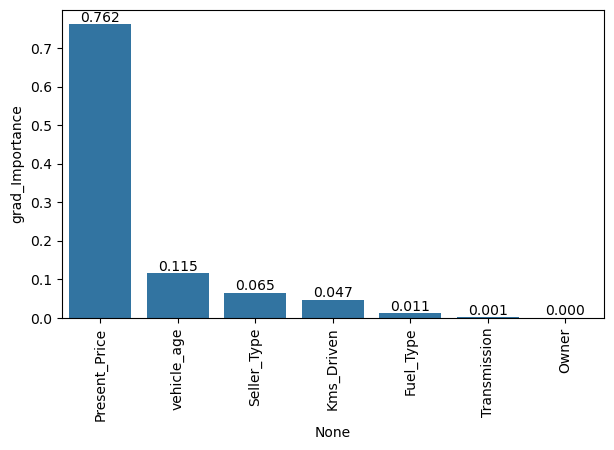

In [59]:
ax = sns.barplot(data=grad_imp_feats,
                 x=grad_imp_feats.index,
                 y='grad_Importance')

ax.bar_label(ax.containers[0],fmt="%.3f")
plt.xticks(rotation=90);

## Modeling with Pipeline for XG Boost Regressor

In [60]:
import xgboost as xgb

xgb.__version__

'1.7.3'

In [61]:
from xgboost import XGBRegressor

operations = [("OrdinalEncoder", column_trans),
              ("XGB_model", XGBRegressor(random_state=101))]

pipe_model = Pipeline(steps=operations)

pipe_model.fit(X_train, y_train)

# In classification it is objective='binary:logistic' and in regression it is 'reg:squarederror'.
# Other parameters are the same as classification.

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('XGB_model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              col...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=101, ...))])

In [62]:
train_val(pipe_model, X_train, y_train, X_test, y_test)

,train,test
R2,0.999995,0.951623
mae,0.003799,0.362840
mse,0.000035,0.330514
rmse,0.005921,0.574903
mape,0.002713,0.207221


In [63]:
operations = [("OrdinalEncoder", column_trans),
              ("XGB_model", XGBRegressor(random_state=101))]

model = Pipeline(steps=operations)

scores = cross_validate(model,
                        X_train,
                        y_train,
                        scoring=['r2',
                                 'neg_mean_absolute_error',
                                 'neg_mean_squared_error',
                                 'neg_root_mean_squared_error',
                                 'neg_mean_absolute_percentage_error'],
                        cv =10,
                        return_train_score=True)
pd.DataFrame(scores).iloc[:, 2:].mean()

# overfiting.

test_r2                                     0.937436
train_r2                                    0.999998
test_neg_mean_absolute_error               -0.429135
train_neg_mean_absolute_error              -0.002617
test_neg_mean_squared_error                -0.417644
train_neg_mean_squared_error               -0.000015
test_neg_root_mean_squared_error           -0.625740
train_neg_root_mean_squared_error          -0.003834
test_neg_mean_absolute_percentage_error    -0.172599
train_neg_mean_absolute_percentage_error   -0.001792
dtype: float64

## Gridsearch for XGBoost

In [64]:
XGBRegressor?

Init signature:
XGBRegressor(
    *,
    objective: Union[str, Callable[[numpy.ndarray, numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'reg:squarederror',
    **kwargs: Any,
) -> None
Docstring:     
Implementation of the scikit-learn API for XGBoost regression.


Parameters
----------

    n_estimators : int
        Number of gradient boosted trees.  Equivalent to number of boosting
        rounds.

    max_depth :  Optional[int]
        Maximum tree depth for base learners.
    max_leaves :
        Maximum number of leaves; 0 indicates no limit.
    max_bin :
        If using histogram-based algorithm, maximum number of bins per feature
    grow_policy :
        Tree growing policy. 0: favor splitting at nodes closest to the node, i.e. grow
        depth-wise. 1: favor splitting at nodes with highest loss change.
    learning_rate : Optional[float]
        Boosting learning rate (xgb's "eta")
    verbosity : Optional[int]
        The degree of verbosity. Valid valu

In [65]:
param_grid = {"XGB_model__n_estimators":[30,35],
              "XGB_model__max_depth":[5, 3],
              "XGB_model__learning_rate": [0.055, 0.06],
              "XGB_model__subsample": [0.5, 0.8],
              "XGB_model__colsample_bytree":[0.5, 0.8, 1],
              "XGB_model__colsample_bylevel":[0.5, 0.8, 1],

              }

In [66]:
operations = [("OrdinalEncoder", column_trans),
              ("XGB_model", XGBRegressor(random_state=101))]

model = Pipeline(steps=operations)

grid_model = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring='neg_mean_absolute_percentage_error',
                          cv=10,
                          n_jobs=-1,
                          return_train_score=True)

In [67]:
grid_model.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('OrdinalEncoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object'))],
                                                          verbose_feature_names_out=False)),
                                       ('XGB_model',
                                        XGBRegressor(base_score=None,
                                                     bo...
                                                     predictor=None,
                                                     random_state=101, ...))]),
             n_jobs=-1,
             param_grid={'XGB_model__colsample_bylevel': [0.5, 0.8, 1],
                         'XGB_model__colsample_bytree': [0.5, 0.8, 1],
                         'XGB_model__learning_rate': [0.055, 0.06],
                         'XGB_model__max_depth': [5, 3],
                         'XGB_model__n_estimators': [30, 35],
                         'XGB_model__subsample': [0.5, 0.8]},
             return_train_score=True,
             scoring='neg_mean_absolute_percentage_error')

In [68]:
grid_model.best_params_

{'XGB_model__colsample_bylevel': 0.8,
 'XGB_model__colsample_bytree': 1,
 'XGB_model__learning_rate': 0.06,
 'XGB_model__max_depth': 5,
 'XGB_model__n_estimators': 35,
 'XGB_model__subsample': 0.8}

In [69]:
grid_model.best_estimator_

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('XGB_model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              col...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.06,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=35,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=101, ...))])

In [70]:
pd.DataFrame(grid_model.cv_results_).loc[grid_model.best_index_, ["mean_test_score", "mean_train_score"]]

# no overfiting.

mean_test_score    -0.175607
mean_train_score   -0.123563
Name: 91, dtype: object

In [71]:
prediction = grid_model.predict(X_test)

xgb_rmse = mean_squared_error(y_test, prediction, squared=False)

train_val(grid_model, X_train, y_train, X_test, y_test)
# We do not approve this model because the average of the test data and the validation set scores
# we got from the CV is not consistent.

,train,test
R2,0.931305,0.913698
mae,0.444627,0.498337
mse,0.495671,0.589614
rmse,0.704039,0.767864
mape,0.123411,0.228053


## Feature importance

In [72]:
# Remove 'XGB_model__' prefix from parameter keys
best_params3 = {key.replace('XGB_model__', ''): value for key, value in grid_model.best_params_.items()}

In [73]:
operations = [("OrdinalEncoder", column_trans),
              ("XGB_model", XGBRegressor(**best_params3))]

pipe_model = Pipeline(steps=operations)

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('XGB_model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              col...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.06,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=35,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [74]:
pipe_model["XGB_model"].feature_importances_

array([0.16771474, 0.41040233, 0.00348645, 0.34103993, 0.03017785,
       0.000999  , 0.0461797 ], dtype=float32)

In [75]:
features

array(['Fuel_Type', 'Seller_Type', 'Transmission', 'Present_Price',
       'Kms_Driven', 'Owner', 'vehicle_age'], dtype=object)

In [76]:
imp_feats = pd.DataFrame(data=pipe_model["XGB_model"].feature_importances_,
                         columns=['xgb_Importance'],
                         index=features)

xgb_imp_feats = imp_feats.sort_values('xgb_Importance', ascending=False)
xgb_imp_feats

,xgb_Importance
Seller_Type,0.410402
Present_Price,0.341040
Fuel_Type,0.167715
vehicle_age,0.046180
Kms_Driven,0.030178
Transmission,0.003486
Owner,0.000999


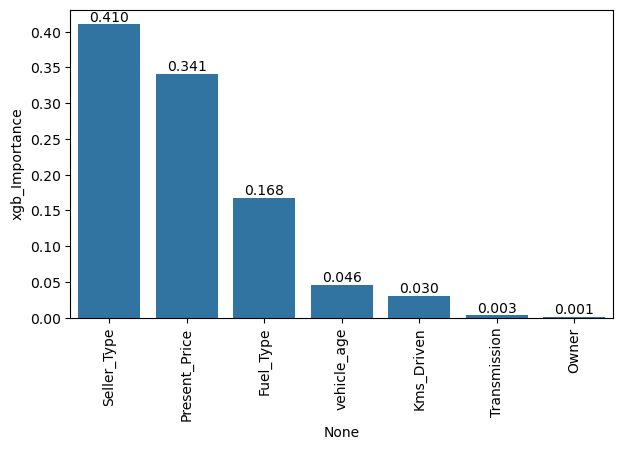

In [77]:
ax = sns.barplot(data=xgb_imp_feats,
                 x=xgb_imp_feats.index,
                 y='xgb_Importance')

ax.bar_label(ax.containers[0],fmt="%.3f")
plt.xticks(rotation=90);

## Feature importance comparison

In [78]:
pd.concat([xgb_imp_feats, grad_imp_feats, ada_imp_feats], axis=1)

,xgb_Importance,grad_Importance,ada_Importance
Seller_Type,0.410402,0.064754,0.006301
Present_Price,0.341040,0.761726,0.541419
Fuel_Type,0.167715,0.011146,0.071285
vehicle_age,0.046180,0.114952,0.255909
Kms_Driven,0.030178,0.046693,0.119387
Transmission,0.003486,0.000730,0.005697
Owner,0.000999,0.000000,0.000003


## Comparing scores

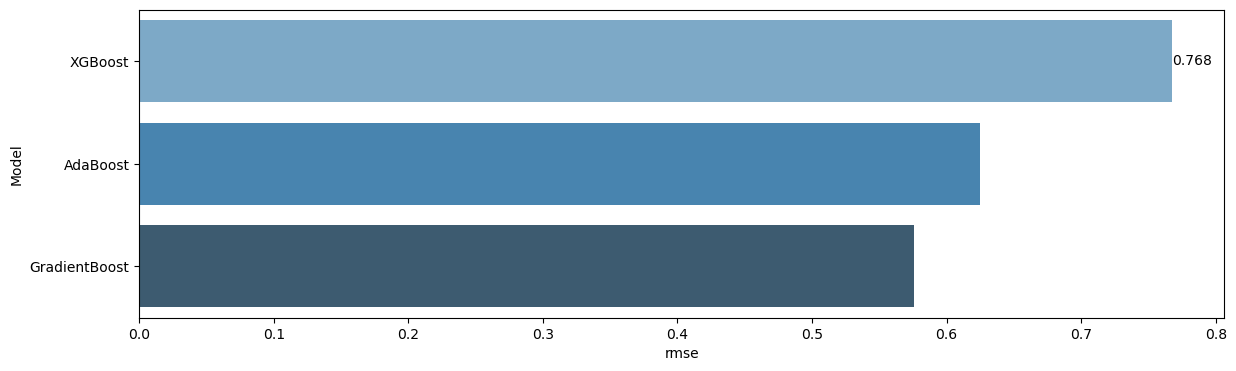

In [79]:
compare = pd.DataFrame({"Model": ["AdaBoost","GradientBoost", "XGBoost"],
                        "rmse": [ada_rmse, gradient_rmse, xgb_rmse]})

plt.figure(figsize=(14,4))

compare = compare.sort_values(by="rmse", ascending=False)
ax=sns.barplot(x="rmse",
               y="Model",
               data=compare,
               palette="Blues_d")
ax.bar_label(ax.containers[0],fmt="%.3f")
plt.show();

In [80]:
# According to the rmse scores above,
# XGBoost seems not to be the best score and it was not consistent, but it is still a lot hyperparameter to tune it.
# Adaboost consistent and generalized.
# We prefer Gradient Boosting because it gives the most consistent score with CV.

## Final Model

In [81]:
cat

Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object')

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer

ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value',
                         unknown_value=-1)

column_trans = make_column_transformer((ord_enc, cat),
                                        remainder='passthrough',
                                        verbose_feature_names_out=False).set_output(transform="pandas")


operations = [("OrdinalEncoder", column_trans),
              ("Ada_model", GradientBoostingRegressor(**best_params2))]

pipe_model = Pipeline(steps=operations)
pipe_model.fit(X, y)

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('Ada_model',
                 GradientBoostingRegressor(ccp_alpha=0.01, max_features=6,
                                           subsample=0.5))])

In [83]:
pipe_model["OrdinalEncoder"].fit_transform(X).head()

,Fuel_Type,Seller_Type,Transmission,Present_Price,Kms_Driven,Owner,vehicle_age
0,2.0,0.0,1.0,5.59,27000,0,8
1,1.0,0.0,1.0,9.54,43000,0,9
2,2.0,0.0,1.0,9.85,6900,0,5
3,2.0,0.0,1.0,4.15,5200,0,11
4,1.0,0.0,1.0,6.87,42450,0,8


## Prediction

In [84]:
samples = {"Present_Price": [7, 9.5],
           "Kms_Driven": [25000, 44000],
           "Fuel_Type":["Petrol", "Diesel"],
           'Seller_Type':['Dealer', 'Individual'],
           'Transmission': ['Manual', 'Automatic'],
           "Owner":[0,1],
           "vehicle_age":[1, 9]}

In [85]:
df_samples = pd.DataFrame(samples)
df_samples

,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,vehicle_age
0,7.0,25000,Petrol,Dealer,Manual,0,1
1,9.5,44000,Diesel,Individual,Automatic,1,9


In [86]:
pipe_model.predict(df_samples)

array([5.64936632, 5.09415454])

END OF THE PROJECT